- Amayas SADI 28717408
- Ghiles OUHENIA 28716807

# TME 7 - Approches par modeles de substitution

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, _tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.datasets import load_iris

import pydotplus
from IPython.display import display, Image

import pandas as pd
import numpy as np


import warnings
warnings.filterwarnings("ignore")

## Exercice 1 : Construction de r`egles contre-factuelles

#### Q1.Choisir un ensemble de donnees et le separer en une base d’apprentissage et une base de test

In [156]:
data = load_iris()

X = data.data
y = data.target

In [157]:
X[:3]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

In [158]:
y[:3]

array([0, 0, 0])

In [159]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### Q2.Construire un arbre de d ́ecision avec la base d’apprentissage

In [160]:
# Initialiser et entraîner l'arbre de décision symbolique
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Évaluer la précision de l'arbre de décision
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.4f}%")

Accuracy: 100.0000%


#### Q3.Choisir un exemple de la base de test comme exemple de référence x. Le classer avec l’arbre de décision et afficher la regle activee pour son classement

In [161]:
x = X_test[0]
x

array([6.1, 2.8, 4.7, 1.2])

In [162]:
clf.predict([x])

array([1])

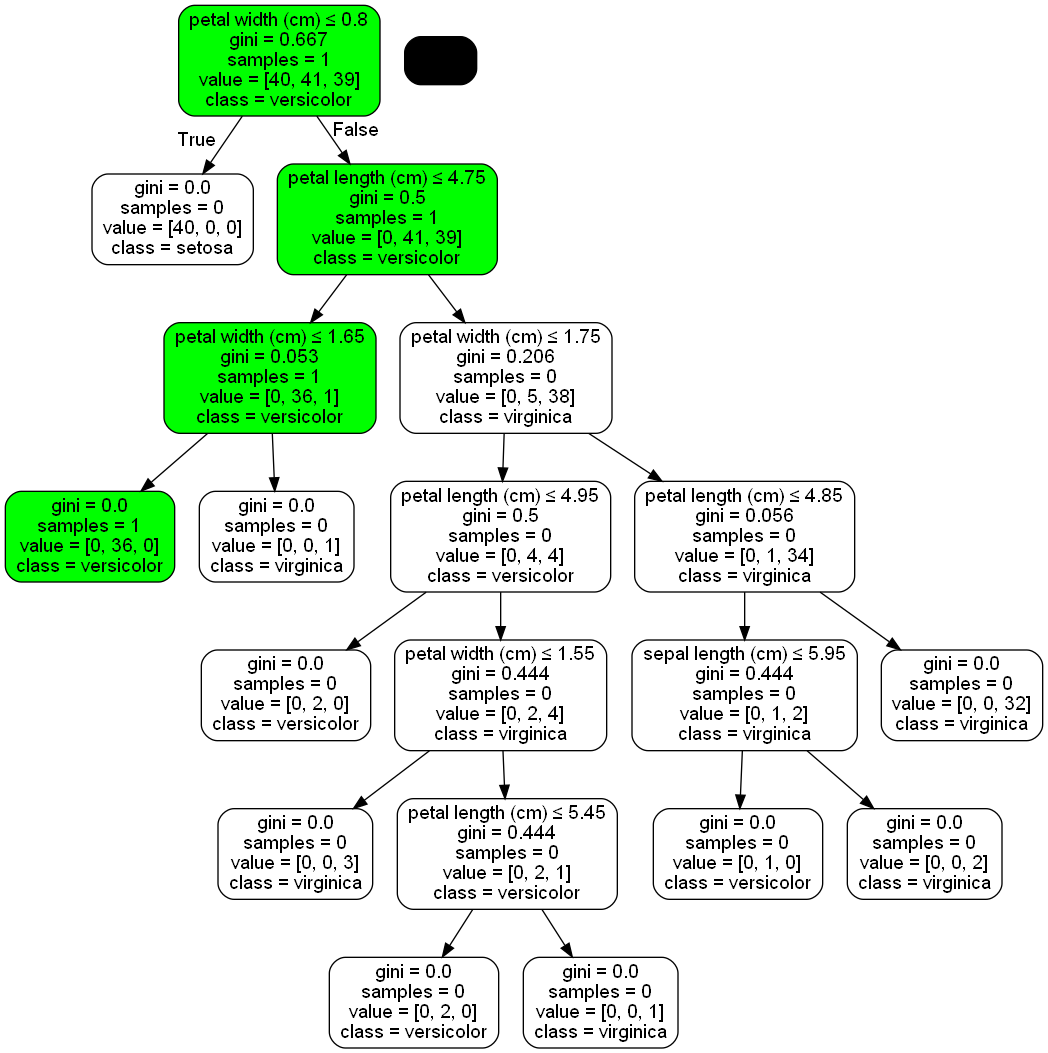

In [163]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=data.feature_names,
                                class_names=data.target_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)

# empty all nodes, i.e.set color to white and number of samples to zero
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')

decision_paths = clf.decision_path([x])

for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
        if node_value == 0:
            continue
        node = graph.get_node(str(n))[0]            
        node.set_fillcolor('green')
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

        node.set('label', '<br/>'.join(labels))

filename = 'tree.png'
graph.write_png(filename)

img = Image(filename)
display(img)

#### Q4.Afficher toutes les règles contre-factuelles r' ainsi que nr' leur nombre de tests invalidés pour x.

In [164]:
def find_all_counterfactuals(tree, feature_names, example, target_value):
    tree_ = tree.tree_
    counterfactuals = []

    def recurse(node, path_conditions, nrs):
    
        if tree_.children_left[node] == tree_.children_right[node]:
            if np.argmax(tree_.value[node]) != target_value:
                counterfactuals.append((path_conditions.copy(), (~np.array(nrs)).sum()))
            return

        feature = feature_names[tree_.feature[node]]
        threshold = tree_.threshold[node]

        left_conditions = path_conditions.copy()
        left_conditions.append(f"{feature} <= {threshold}")

        nrs_left = nrs.copy()
        nrs_left.append(example[tree_.feature[node]] <= threshold)

        recurse(tree_.children_left[node], left_conditions, nrs_left)

        right_conditions = path_conditions.copy()
        right_conditions.append(f"{feature} > {threshold}")

        nrs_right = nrs.copy()
        nrs_right.append(example[tree_.feature[node]] > threshold)

        recurse(tree_.children_right[node], right_conditions, nrs_right)

    recurse(0, [], [])
    return counterfactuals

# Find all counterfactuals for the first example in the test set
all_counterfactual_rules = find_all_counterfactuals(clf, data.feature_names, X_test[10], y_test[10])

# Print all the counterfactual rules
for cf in all_counterfactual_rules:
    for r in cf[0]:
        print("\t", r)

    print("\t ==========>> Nr :", cf[1])
    print("\n")

	 petal width (cm) <= 0.800000011920929
	 ==========>> Nr : 1


	 petal width (cm) > 0.800000011920929
	 petal length (cm) <= 4.75
	 petal width (cm) <= 1.6500000357627869
	 ==========>> Nr : 2


	 petal width (cm) > 0.800000011920929
	 petal length (cm) > 4.75
	 petal width (cm) <= 1.75
	 petal length (cm) <= 4.950000047683716
	 ==========>> Nr : 2


	 petal width (cm) > 0.800000011920929
	 petal length (cm) > 4.75
	 petal width (cm) <= 1.75
	 petal length (cm) > 4.950000047683716
	 petal width (cm) > 1.550000011920929
	 petal length (cm) <= 5.450000047683716
	 ==========>> Nr : 1


	 petal width (cm) > 0.800000011920929
	 petal length (cm) > 4.75
	 petal width (cm) > 1.75
	 petal length (cm) <= 4.8500001430511475
	 sepal length (cm) <= 5.950000047683716
	 ==========>> Nr : 2




#### Q5.Proposer une explication pour la classification de x par l’arbre de decision.

In [165]:
def tree_to_code(tree, feature_names, example):
    """
    Outputs a decision tree model as a Python function, but only for the path taken by a given example
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    decision_path = set(tree.decision_path([example]).indices)

    def recurse(node, depth):
        if node in decision_path:
            indent = "  " * depth
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                name = feature_name[node]
                threshold = tree_.threshold[node]
                if example[tree_.feature[node]] <= threshold:
                    return f"{indent}{name} <= {threshold}:\n" + recurse(tree_.children_left[node], depth + 1)
                else:
                    return f"{indent}{name} > {threshold}\n" + recurse(tree_.children_right[node], depth + 1)
            else:
                return f"{indent}return {tree.predict([example])[0]}\n"
        else:
            return ""

    return recurse(0, 1)

def explain_classification(model, example, feature_names):
    # Récupérer le chemin de décision et expliquer en se basant sur les règles activées
    explanation = "L'exemple a été classé comme {} parce que : \n".format(model.predict([example])[0])
    explanation += tree_to_code(model, feature_names, example)
    return explanation

def present_explanation_feature_ranges(explanation, model, example, feature_names):
    """
    Present the classification explanation with a summary of important features and their best range.
    """
    print("Explication de la Classification :\n")
    print(explanation)

    # Identify the important features used in the decision and their best ranges
    print("\nRésumé des Caractéristiques Importantes avec Plages Optimales :\n")
    decision_path = set(model.decision_path([example]).indices)
    feature_ranges = {}

    for node in decision_path:
        if model.tree_.feature[node] != _tree.TREE_UNDEFINED:
            feature_index = model.tree_.feature[node]
            feature = feature_names[feature_index]
            threshold = model.tree_.threshold[node]

            # Initialize the range for this feature
            if feature not in feature_ranges:
                feature_ranges[feature] = [float('-inf'), float('inf')]

            # Update the range based on the decision path
            if example[feature_index] <= threshold:
                feature_ranges[feature][1] = min(feature_ranges[feature][1], threshold)
            else:
                feature_ranges[feature][0] = max(feature_ranges[feature][0], threshold)

    # Print the best feature ranges
    for feature, (lower, upper) in feature_ranges.items():
        lower_str = f"{lower:.2f}" if lower != float('-inf') else "-inf"
        upper_str = f"{upper:.2f}" if upper != float('inf') else "+inf"
        range_str = f"entre {lower_str} et {upper_str}" if lower_str != "-inf" or upper_str != "+inf" else f"{lower_str}{upper_str}"
        if isinstance(feature_names, np.ndarray):
            tmp = feature_index = np.where(feature_names == feature)[0][0]
            print(f"Caractéristique: {feature}, Valeur: {example[tmp]}, Plage: {range_str}")
        else : 
            print(f"Caractéristique: {feature}, Valeur: {example[feature_names.index(feature)]}, Plage: {range_str}")

idx = 5

# Appel de la fonction
explanation = explain_classification(clf, X_test[idx], data.feature_names)

# Présenter l'explication avec un résumé des caractéristiques et de leurs plages optimales
present_explanation_feature_ranges(explanation, clf, X_test[idx], data.feature_names)

Explication de la Classification :

L'exemple a été classé comme 0 parce que : 
  petal width (cm) <= 0.800000011920929:
    return 0


Résumé des Caractéristiques Importantes avec Plages Optimales :

Caractéristique: petal width (cm), Valeur: 0.4, Plage: entre -inf et 0.80


#### Q6.Proposer une m ́ethode de votre choix pour pr ́esenter à l’utilisateur l’explication fournie à la question précédente

In [166]:
idx = int(input("Entrez un numéro d'exemple à expliquer : "))

# Générer l'explication pour un exemple spécifique
explanation = explain_classification(clf, X_test[idx], data.feature_names)

# Présenter l'explication avec un résumé des caractéristiques et de leurs plages optimales
present_explanation_feature_ranges(explanation, clf, X_test[idx], data.feature_names)

Explication de la Classification :

L'exemple a été classé comme 2 parce que : 
  petal width (cm) > 0.800000011920929
    petal length (cm) > 4.75
      petal width (cm) > 1.75
        petal length (cm) > 4.8500001430511475
          return 2


Résumé des Caractéristiques Importantes avec Plages Optimales :

Caractéristique: petal width (cm), Valeur: 2.3, Plage: entre 1.75 et +inf
Caractéristique: petal length (cm), Valeur: 5.9, Plage: entre 4.85 et +inf


# Exercice 2 Génération de bases d’apprentissage et d’explications

#### Q1.En vous inspirant des impl ́ementations que vous avez deja realis ́ees, ou de l’approche LORE, ecrire une fonction qui,  ́etant donn ́e un classifieur f (celui que vous voulez, appris sur votre base d’apprentissage de l’exercice pr ́ec ́edent) et un exemple de r ́ef ́erence x, g ́en ́ere une base d’apprentissage pour construire un modele de substitution

In [167]:

def generate_substitute_training_data(classifier, reference_example, feature_variation=0.1, num_samples=100):
    """
    Generate a training dataset for a substitute model.

    :param classifier: The original classifier (f).
    :param reference_example: The reference example (x).
    :param feature_variation: The percentage variation for each feature.
    :param num_samples: The number of samples to generate.
    :return: A tuple of (X, y) where X is the generated samples and y are the labels predicted by the original classifier.
    """
    num_features = reference_example.shape[0]
    new_samples = []

    # Generate samples by varying each feature of the reference example
    for _ in range(num_samples):
        sample = np.copy(reference_example)
        for feature in range(num_features):
            variation = np.random.uniform(-feature_variation, feature_variation)
            sample[feature] += variation * reference_example[feature]
        new_samples.append(sample)

    # Convert the list of samples to a numpy array
    new_samples = np.array(new_samples)

    # Use the original classifier to label these new samples
    labels = classifier.predict(new_samples)

    return new_samples, labels

# Example usage
# Assuming clf is the original classifier and X_test[0] is the reference example
# Generate training data for the substitute model
substitute_training_data = generate_substitute_training_data(clf, X_test[0])

# The substitute_training_data contains the generated samples and their predicted labels
# This can now be used to train a substitute model

substitute_training_data

(array([[5.91708007, 2.84510297, 4.56005688, 1.14702808],
        [5.95767777, 2.82172858, 4.99085602, 1.18945226],
        [6.16267084, 2.8939532 , 4.686905  , 1.1183953 ],
        [5.52893264, 2.89091797, 4.42648508, 1.29366521],
        [6.33329589, 3.01737667, 5.04505408, 1.15940116],
        [5.53251157, 2.59266665, 4.50813583, 1.15847457],
        [6.26360702, 2.67683835, 4.23538935, 1.14721306],
        [6.61306097, 2.64599561, 4.92607532, 1.08136431],
        [6.44053481, 3.07923597, 4.88822206, 1.25778301],
        [6.5674944 , 2.89905752, 4.49818111, 1.11798326],
        [6.24912071, 2.69150473, 4.27796044, 1.25930576],
        [5.93444835, 2.6066242 , 4.71060124, 1.18359599],
        [5.58185188, 2.60822599, 4.77563136, 1.2029653 ],
        [5.91603438, 2.69803697, 4.43517539, 1.22294655],
        [5.90782972, 2.70391837, 5.04596624, 1.26034259],
        [5.83282286, 2.940495  , 5.05762459, 1.27234456],
        [6.20448863, 3.06335738, 4.27387584, 1.19620887],
        [6.289

#### Q2.Combiner la fonction precedente avec ce que vous avez ecrit dans l’exercice precedent pour ecrire un programme de generation d’explications de la classification par f pour les exemples de la base de test

In [168]:
# Print explanations for the first few test examples
for i in range(5):
    print(f'\n----------------------------------------- Exemple : {i} -----------------------------------------')
    explanations = explain_classification(clf, substitute_training_data[0][i], data.feature_names)
    pres = present_explanation_feature_ranges(explanations, clf, substitute_training_data[0][i], data.feature_names)


----------------------------------------- Exemple : 0 -----------------------------------------
Explication de la Classification :

L'exemple a été classé comme 1 parce que : 
  petal width (cm) > 0.800000011920929
    petal length (cm) <= 4.75:
      petal width (cm) <= 1.6500000357627869:
        return 1


Résumé des Caractéristiques Importantes avec Plages Optimales :

Caractéristique: petal width (cm), Valeur: 1.1470280829686543, Plage: entre 0.80 et 1.65
Caractéristique: petal length (cm), Valeur: 4.560056877018165, Plage: entre -inf et 4.75

----------------------------------------- Exemple : 1 -----------------------------------------
Explication de la Classification :

L'exemple a été classé comme 2 parce que : 
  petal width (cm) > 0.800000011920929
    petal length (cm) > 4.75
      petal width (cm) <= 1.75:
        petal length (cm) > 4.950000047683716
          petal width (cm) <= 1.550000011920929:
            return 2


Résumé des Caractéristiques Importantes avec Plage

# Exercice 3 : Expérimentations

In [169]:
from sklearn.datasets import load_wine, load_breast_cancer

# Fonctions développées dans les exercices précédents
# (par exemple, explain_classification, present_explanation_with_feature_ranges)

# Charger l'ensemble de données Wine
wine = load_wine()
X_wine, y_wine = wine.data, wine.target
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(X_wine, y_wine, test_size=0.2, random_state=42)

# Entraîner un modèle sur l'ensemble de données Wine
clf_wine = DecisionTreeClassifier(random_state=42)
clf_wine.fit(X_wine_train, y_wine_train)

# Charger un autre ensemble de données (par exemple, Breast Cancer)
breast_cancer = load_breast_cancer()
X_bc, y_bc = breast_cancer.data, breast_cancer.target
X_bc_train, X_bc_test, y_bc_train, y_bc_test = train_test_split(X_bc, y_bc, test_size=0.2, random_state=42)

# Entraîner un modèle sur l'ensemble de données Breast Cancer
clf_bc = DecisionTreeClassifier(random_state=42)
clf_bc.fit(X_bc_train, y_bc_train)

# Exécuter les fonctions d'explication sur l'ensemble de données Wine
for i, example in enumerate(X_wine_test[:5]):
    print(f'----------------------------------------- Exemple : {i} -----------------------------------------')
    explanation = explain_classification(clf_wine, example, wine.feature_names)
    present_explanation_feature_ranges(explanation, clf_wine, example, wine.feature_names)

----------------------------------------- Exemple : 0 -----------------------------------------
Explication de la Classification :

L'exemple a été classé comme 0 parce que : 
  color_intensity > 3.819999933242798
    flavanoids > 1.399999976158142
      proline > 724.5
        return 0


Résumé des Caractéristiques Importantes avec Plages Optimales :

Caractéristique: color_intensity, Valeur: 5.1, Plage: entre 3.82 et +inf
Caractéristique: proline, Valeur: 845.0, Plage: entre 724.50 et +inf
Caractéristique: flavanoids, Valeur: 3.03, Plage: entre 1.40 et +inf
----------------------------------------- Exemple : 1 -----------------------------------------
Explication de la Classification :

L'exemple a été classé comme 0 parce que : 
  color_intensity > 3.819999933242798
    flavanoids > 1.399999976158142
      proline > 724.5
        return 0


Résumé des Caractéristiques Importantes avec Plages Optimales :

Caractéristique: color_intensity, Valeur: 5.24, Plage: entre 3.82 et +inf
Carac

In [170]:
# Exécuter les fonctions d'explication sur l'ensemble de données Breast Cancer
for i, example in enumerate(X_bc_test[:5]):
    print(f'----------------------------------------- Exemple : {i} -----------------------------------------')
    explanation = explain_classification(clf_bc, example, breast_cancer.feature_names)
    present_explanation_feature_ranges(explanation, clf_bc, example, breast_cancer.feature_names)

----------------------------------------- Exemple : 0 -----------------------------------------
Explication de la Classification :

L'exemple a été classé comme 1 parce que : 
  mean concave points <= 0.05127999931573868:
    worst radius <= 16.829999923706055:
      area error <= 48.70000076293945:
        worst smoothness <= 0.17764999717473984:
          smoothness error > 0.003309000050649047
            worst texture <= 33.35000038146973:
              return 1


Résumé des Caractéristiques Importantes avec Plages Optimales :

Caractéristique: mean concave points, Valeur: 0.03821, Plage: entre -inf et 0.05
Caractéristique: worst radius, Valeur: 14.97, Plage: entre -inf et 16.83
Caractéristique: area error, Valeur: 30.29, Plage: entre -inf et 48.70
Caractéristique: worst smoothness, Valeur: 0.1426, Plage: entre -inf et 0.18
Caractéristique: smoothness error, Valeur: 0.006953, Plage: entre 0.00 et +inf
Caractéristique: worst texture, Valeur: 24.64, Plage: entre -inf et 33.35
-------